In [1]:
%matplotlib inline

# import packages
import numpy as np
import time 

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import gridspec

from cycler import cycler


In [2]:
# define plot properties
import matplotlib.cm as cm

from matplotlib import rcParams
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable

def rgb(r,g,b):
    return (float(r)/256.,float(g)/256.,float(b)/256.)

cb2 = [rgb(31,120,180), rgb(255,127,0), rgb(51,160,44), rgb(227,26,28), \
       rgb(10,10,10), rgb(253,191,111), rgb(178,223,138), rgb(251,154,153)]

rcParams['figure.figsize'] = (11,7.5)
rcParams['figure.dpi'] = 300

rcParams['lines.linewidth'] = 1

rcParams['axes.prop_cycle'] = cycler('color', cb2)
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid'] = False

rcParams['patch.facecolor'] = cb2[0]
rcParams['patch.edgecolor'] = 'white'

rcParams['font.family'] = 'Bitstream Vera Sans' 
rcParams['font.size'] = 25
rcParams['font.weight'] = 300


> Check the training loss.

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


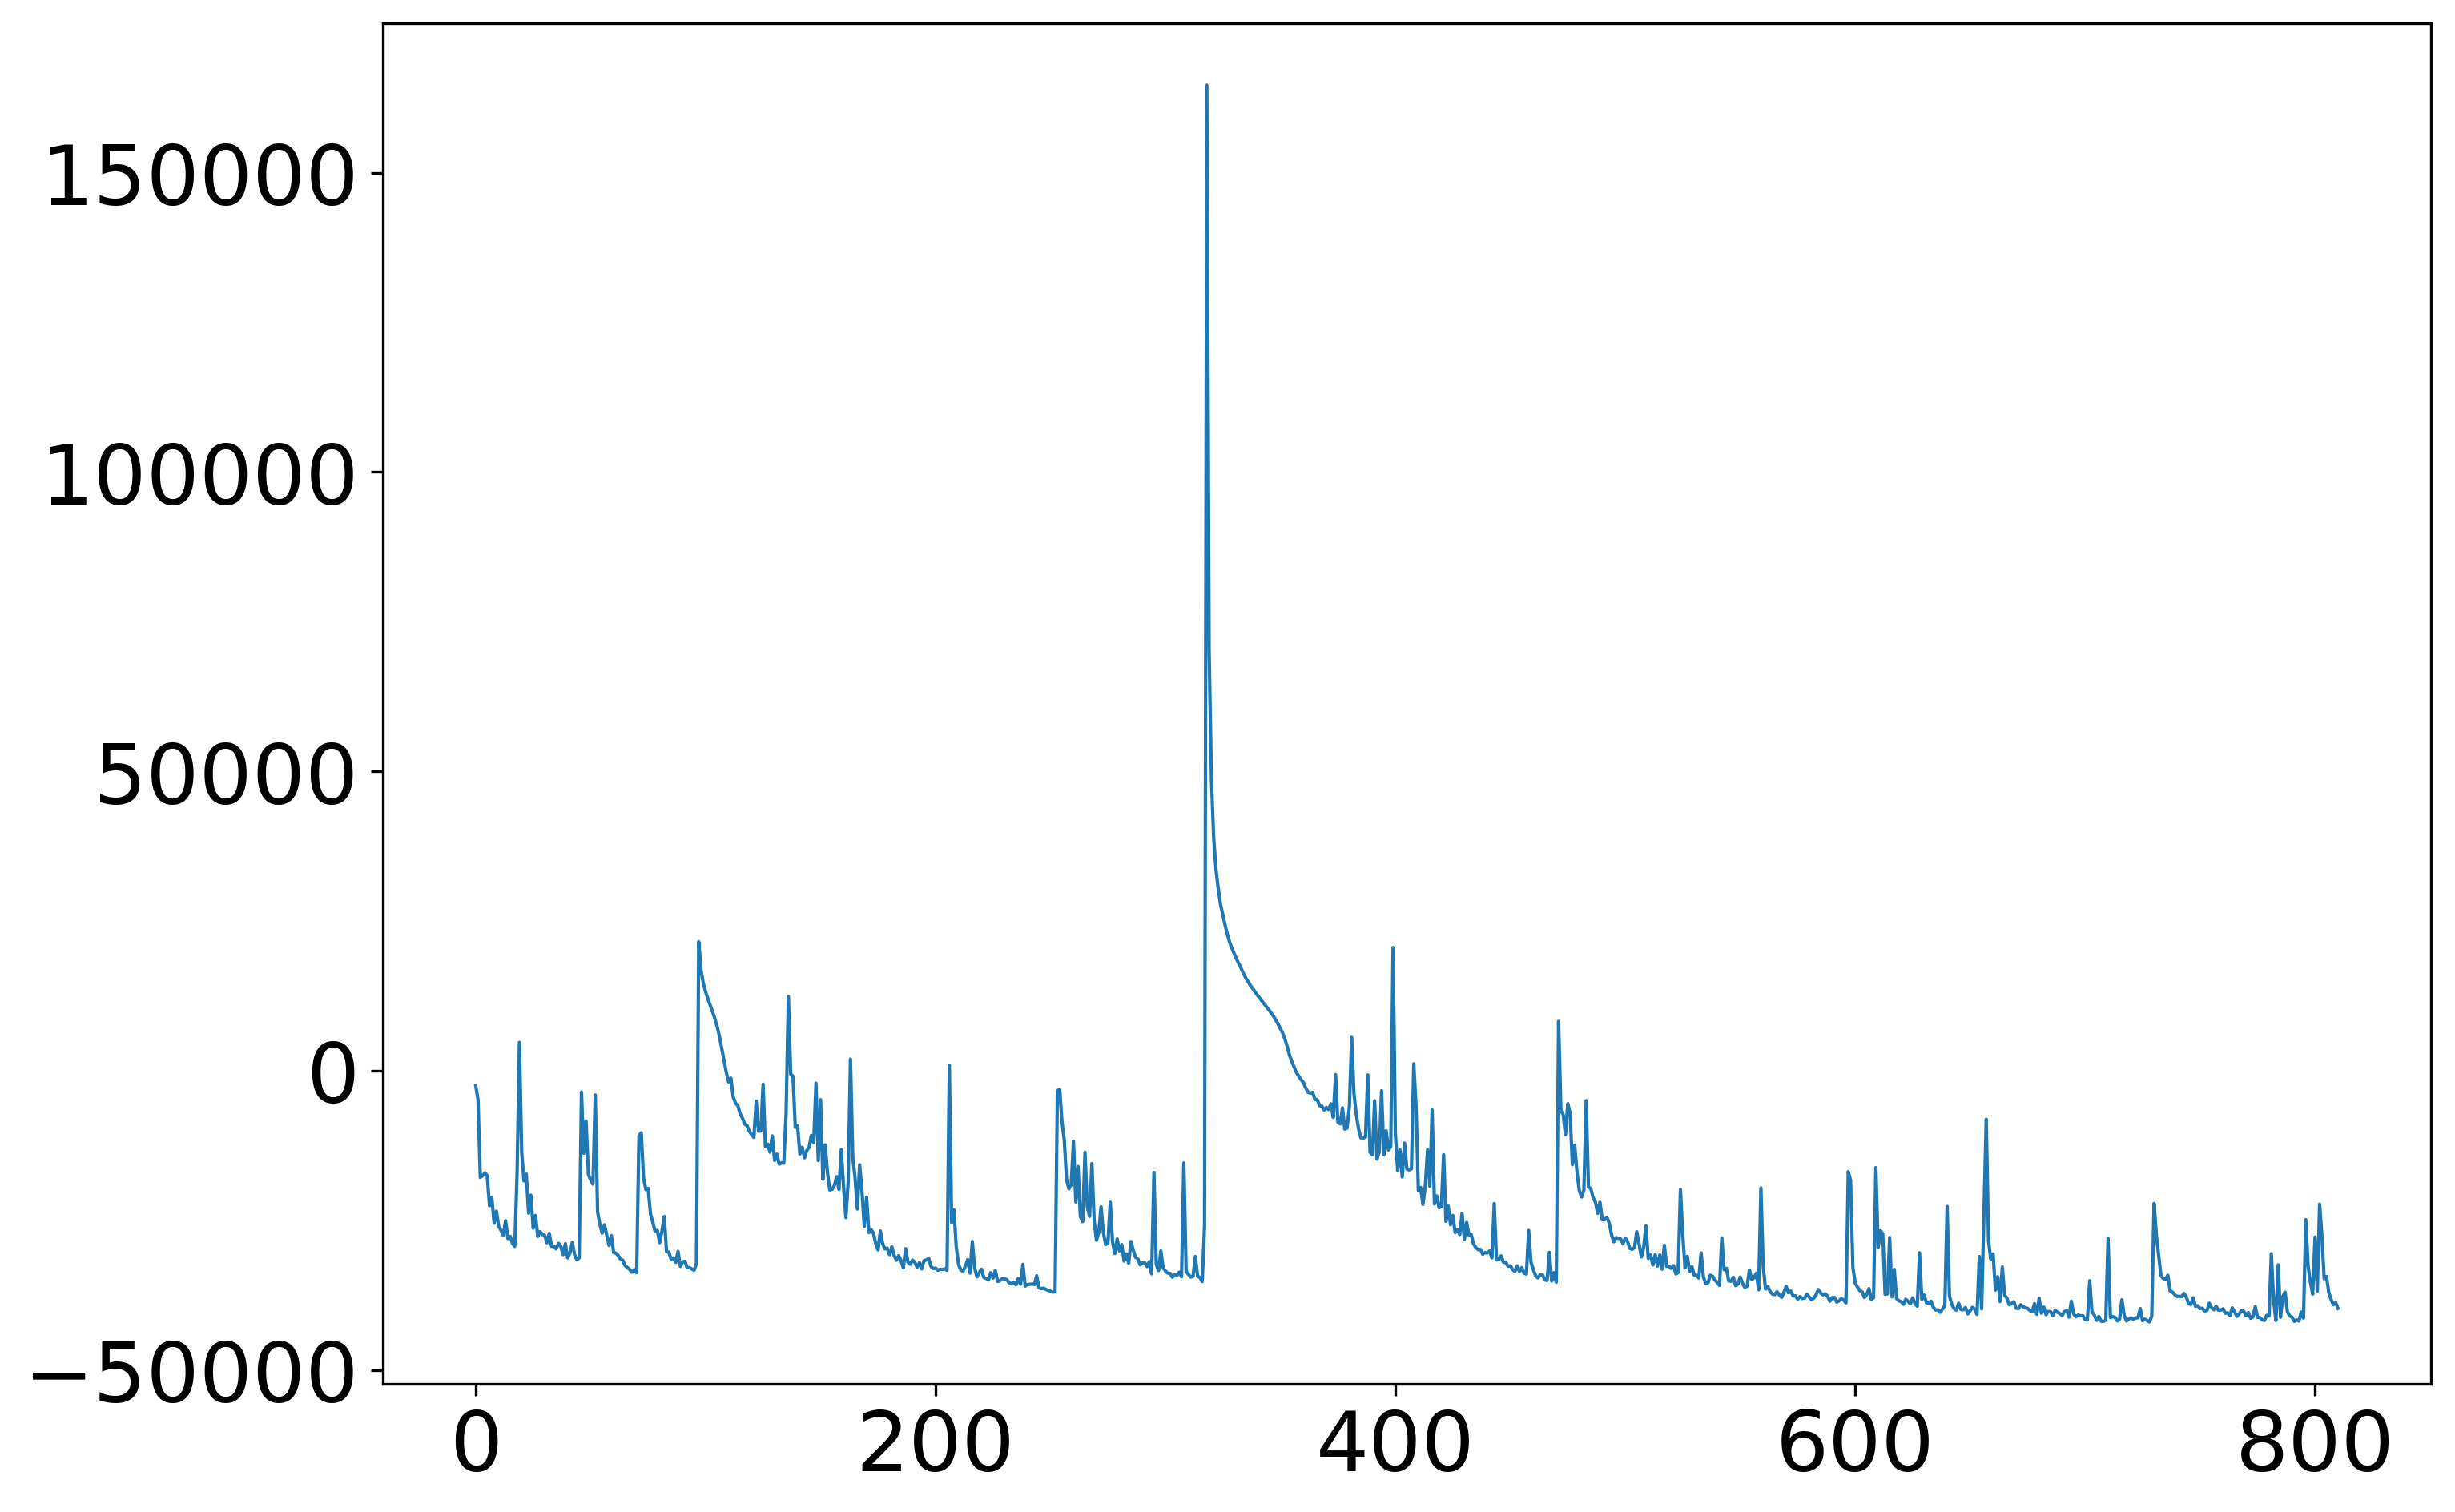

In [3]:
temp = np.load("loss_results_8100.npz")
loss_array = temp["loss_array"]

plt.plot(loss_array)

> Restore trained normalizing flow.

In [4]:
# import packages
import numpy as np
import os

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from torch.autograd import Variable

os.environ['KMP_DUPLICATE_LIB_OK']='True'


#=======================================================================================================
# define normalizing flow
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()

        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])

    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J

    def log_prob(self,x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp

    def sample(self, z):
        x = self.g(z)
        return x
    
    
#==================================================================================
# restore models
flow = torch.load("flow_1400.pt", map_location=lambda storage, loc: storage); # load in cpu
flow.eval();


> Check training vs. validation to make sure the density estimator is well determined.

In [5]:
# restore training data
temp = np.load("mock_all_spectra_no_noise_resample_prior_large.npz")
spectra = temp["spectra"] # num_spectra, num_pixel
labels = temp["labels"] # num_labels, num_spectra
wavelength = temp["wavelength"]
print(spectra.shape)
print(labels.shape)

# randomize array
#ind_shuffle = np.load("ind_shuffle.npy")
#spectra = spectra[ind_shuffle,:]

# convert into torch
y_tr = torch.from_numpy(spectra).type(torch.FloatTensor)

# sample log probablity
log_prob_x = flow.log_prob(y_tr).detach().numpy()


(14623, 7214)
(25, 14623)


/Users/yting/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.
/Users/yting/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


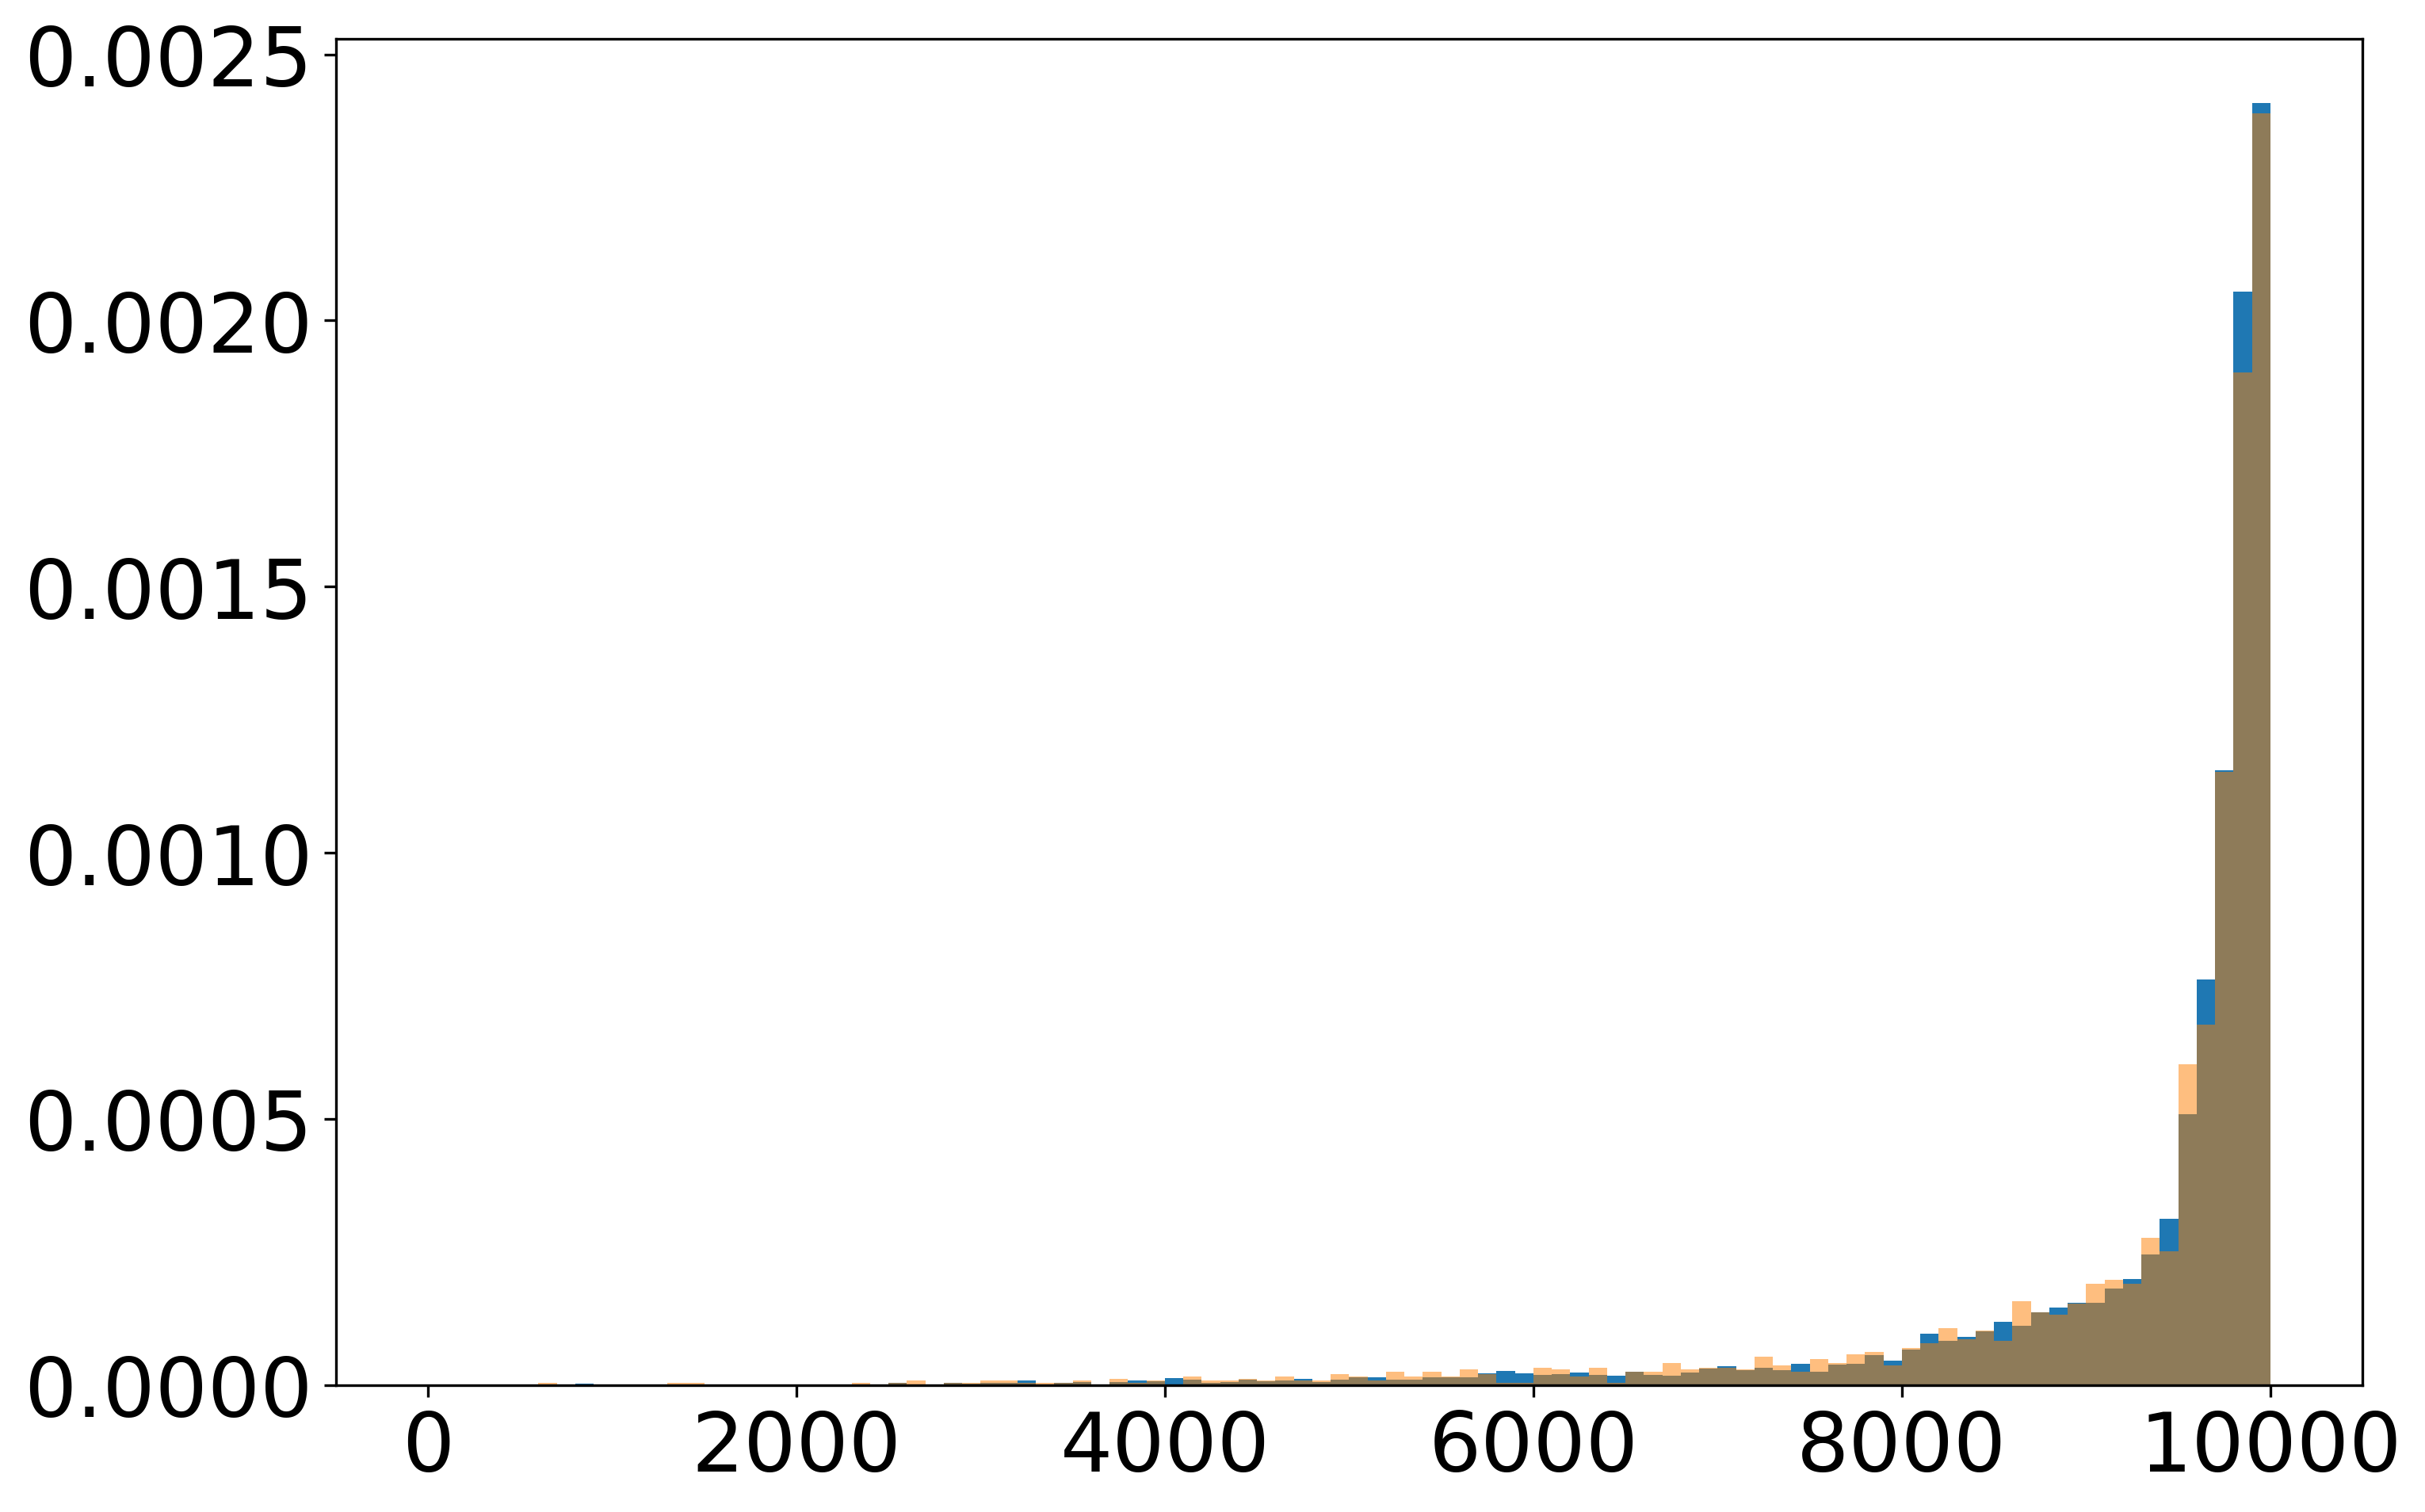

In [6]:
plt.hist(log_prob_x[:12000], bins=100, normed=True, range=[0,10000]);
plt.hist(log_prob_x[12000:], bins=100, normed=True, range=[0,10000], alpha=0.5);

> Check how the probability depends on Teff, perform a running mean and define outliers.

In [7]:
# sort by teff
ind_sort = np.argsort(labels[0,:])
log_prob_x = log_prob_x[ind_sort]
spectra = spectra[ind_sort,:]
labels = labels[:,ind_sort]

Remaining spectra: 13629 / 14623


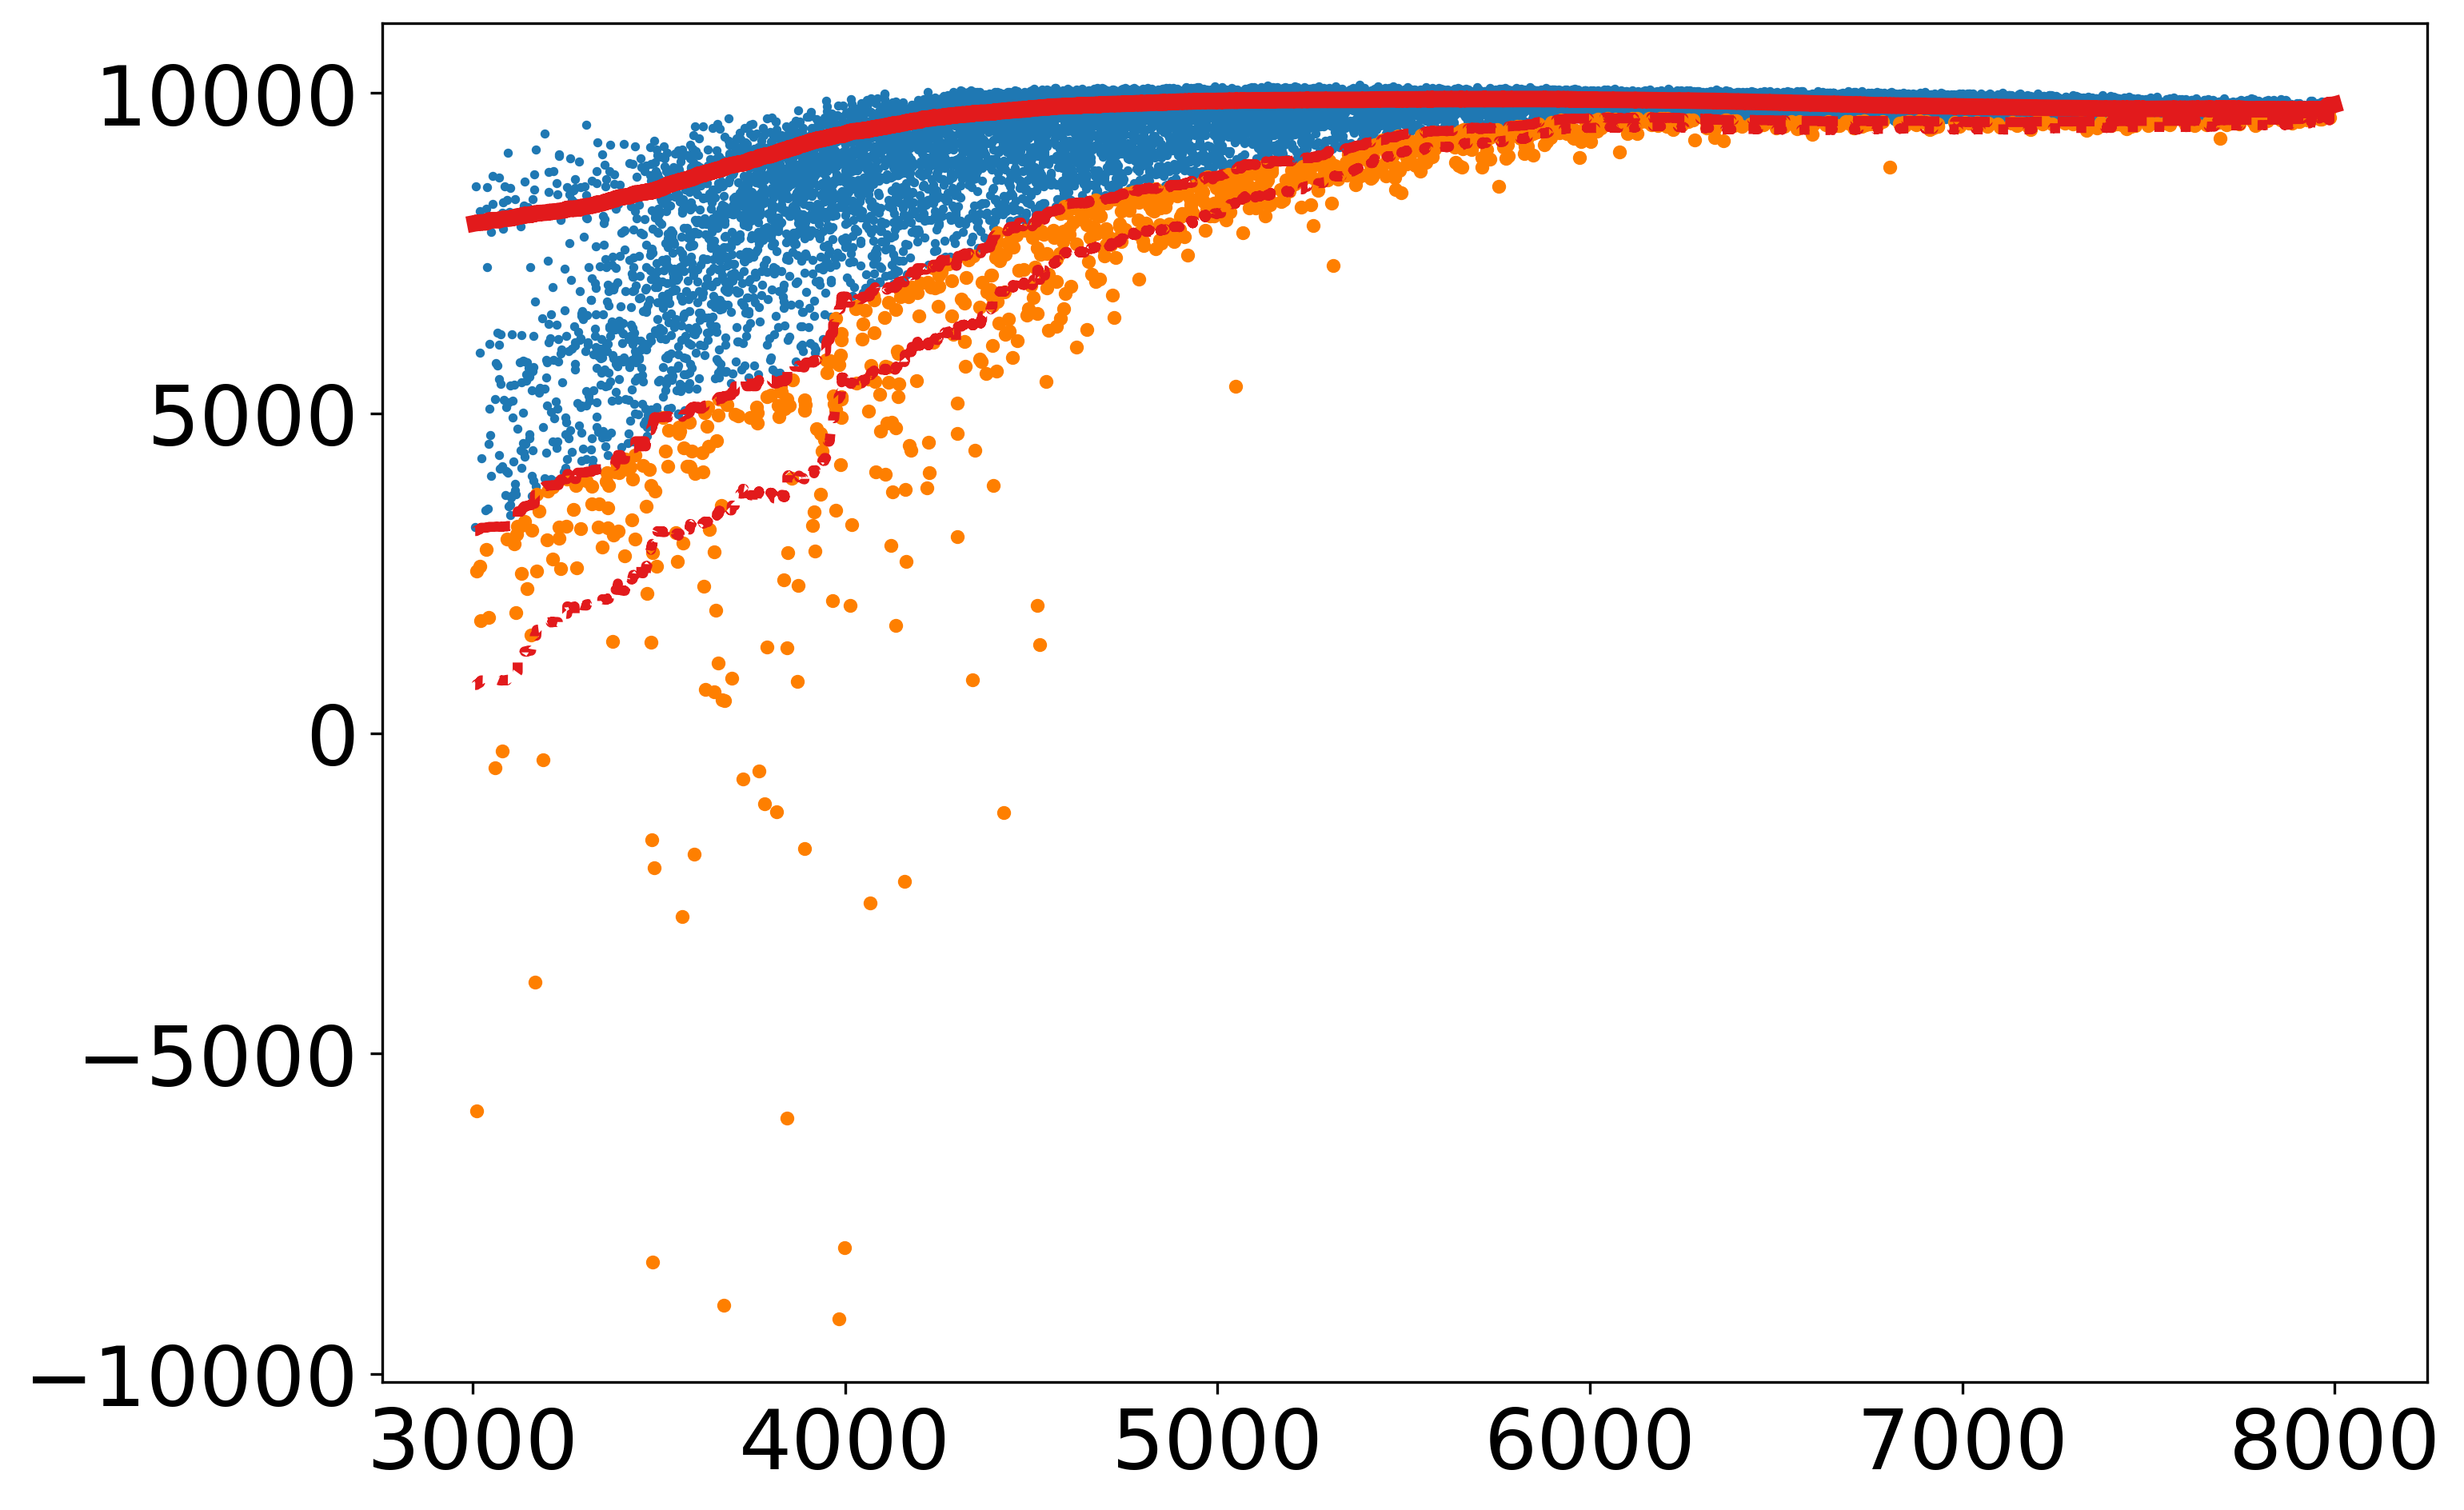

In [36]:
# plot results
teff = labels[0,:]
plt.scatter(teff, log_prob_x, s=3)

# running mean of log prob as a function of teff
low_1sigma = np.array([np.percentile(log_prob_x[i:i+2000], 35.2) for i in range(log_prob_x.size)])
median_log_prob = np.array([np.median(log_prob_x[i:i+2000]) for i in range(log_prob_x.size)])

plt.plot(teff, median_log_prob, color=cb2[3], lw=5)
plt.plot(teff, median_log_prob - 1*(median_log_prob-low_log_prob), color=cb2[3], lw=3, ls="--")
plt.plot(teff, median_log_prob - 1.5*(median_log_prob-low_log_prob), color=cb2[3], lw=3, ls=":")

#--------------------------------------------------------------------------------------------------
# define outliers
sigma_cut = 1.
ind_outliers = log_prob_x < (median_log_prob - sigma_cut*(median_log_prob-low_log_prob))
ind_inside = log_prob_x >= (median_log_prob - sigma_cut*(median_log_prob-low_log_prob))

# plot results
plt.scatter(teff[ind_outliers], log_prob_x[ind_outliers], color=cb2[1], s=10)

print("Remaining spectra:", np.sum(ind_inside), "/", spectra.shape[0])

In [39]:
# save training set excluding the training set
np.savez("mock_all_spectra_no_noise_resample_prior_large_clean.npz",\
         wavelength = wavelength,\
         spectra = spectra[ind_inside,:],\
         labels = labels[:,ind_inside])


> Plot weird spectra.

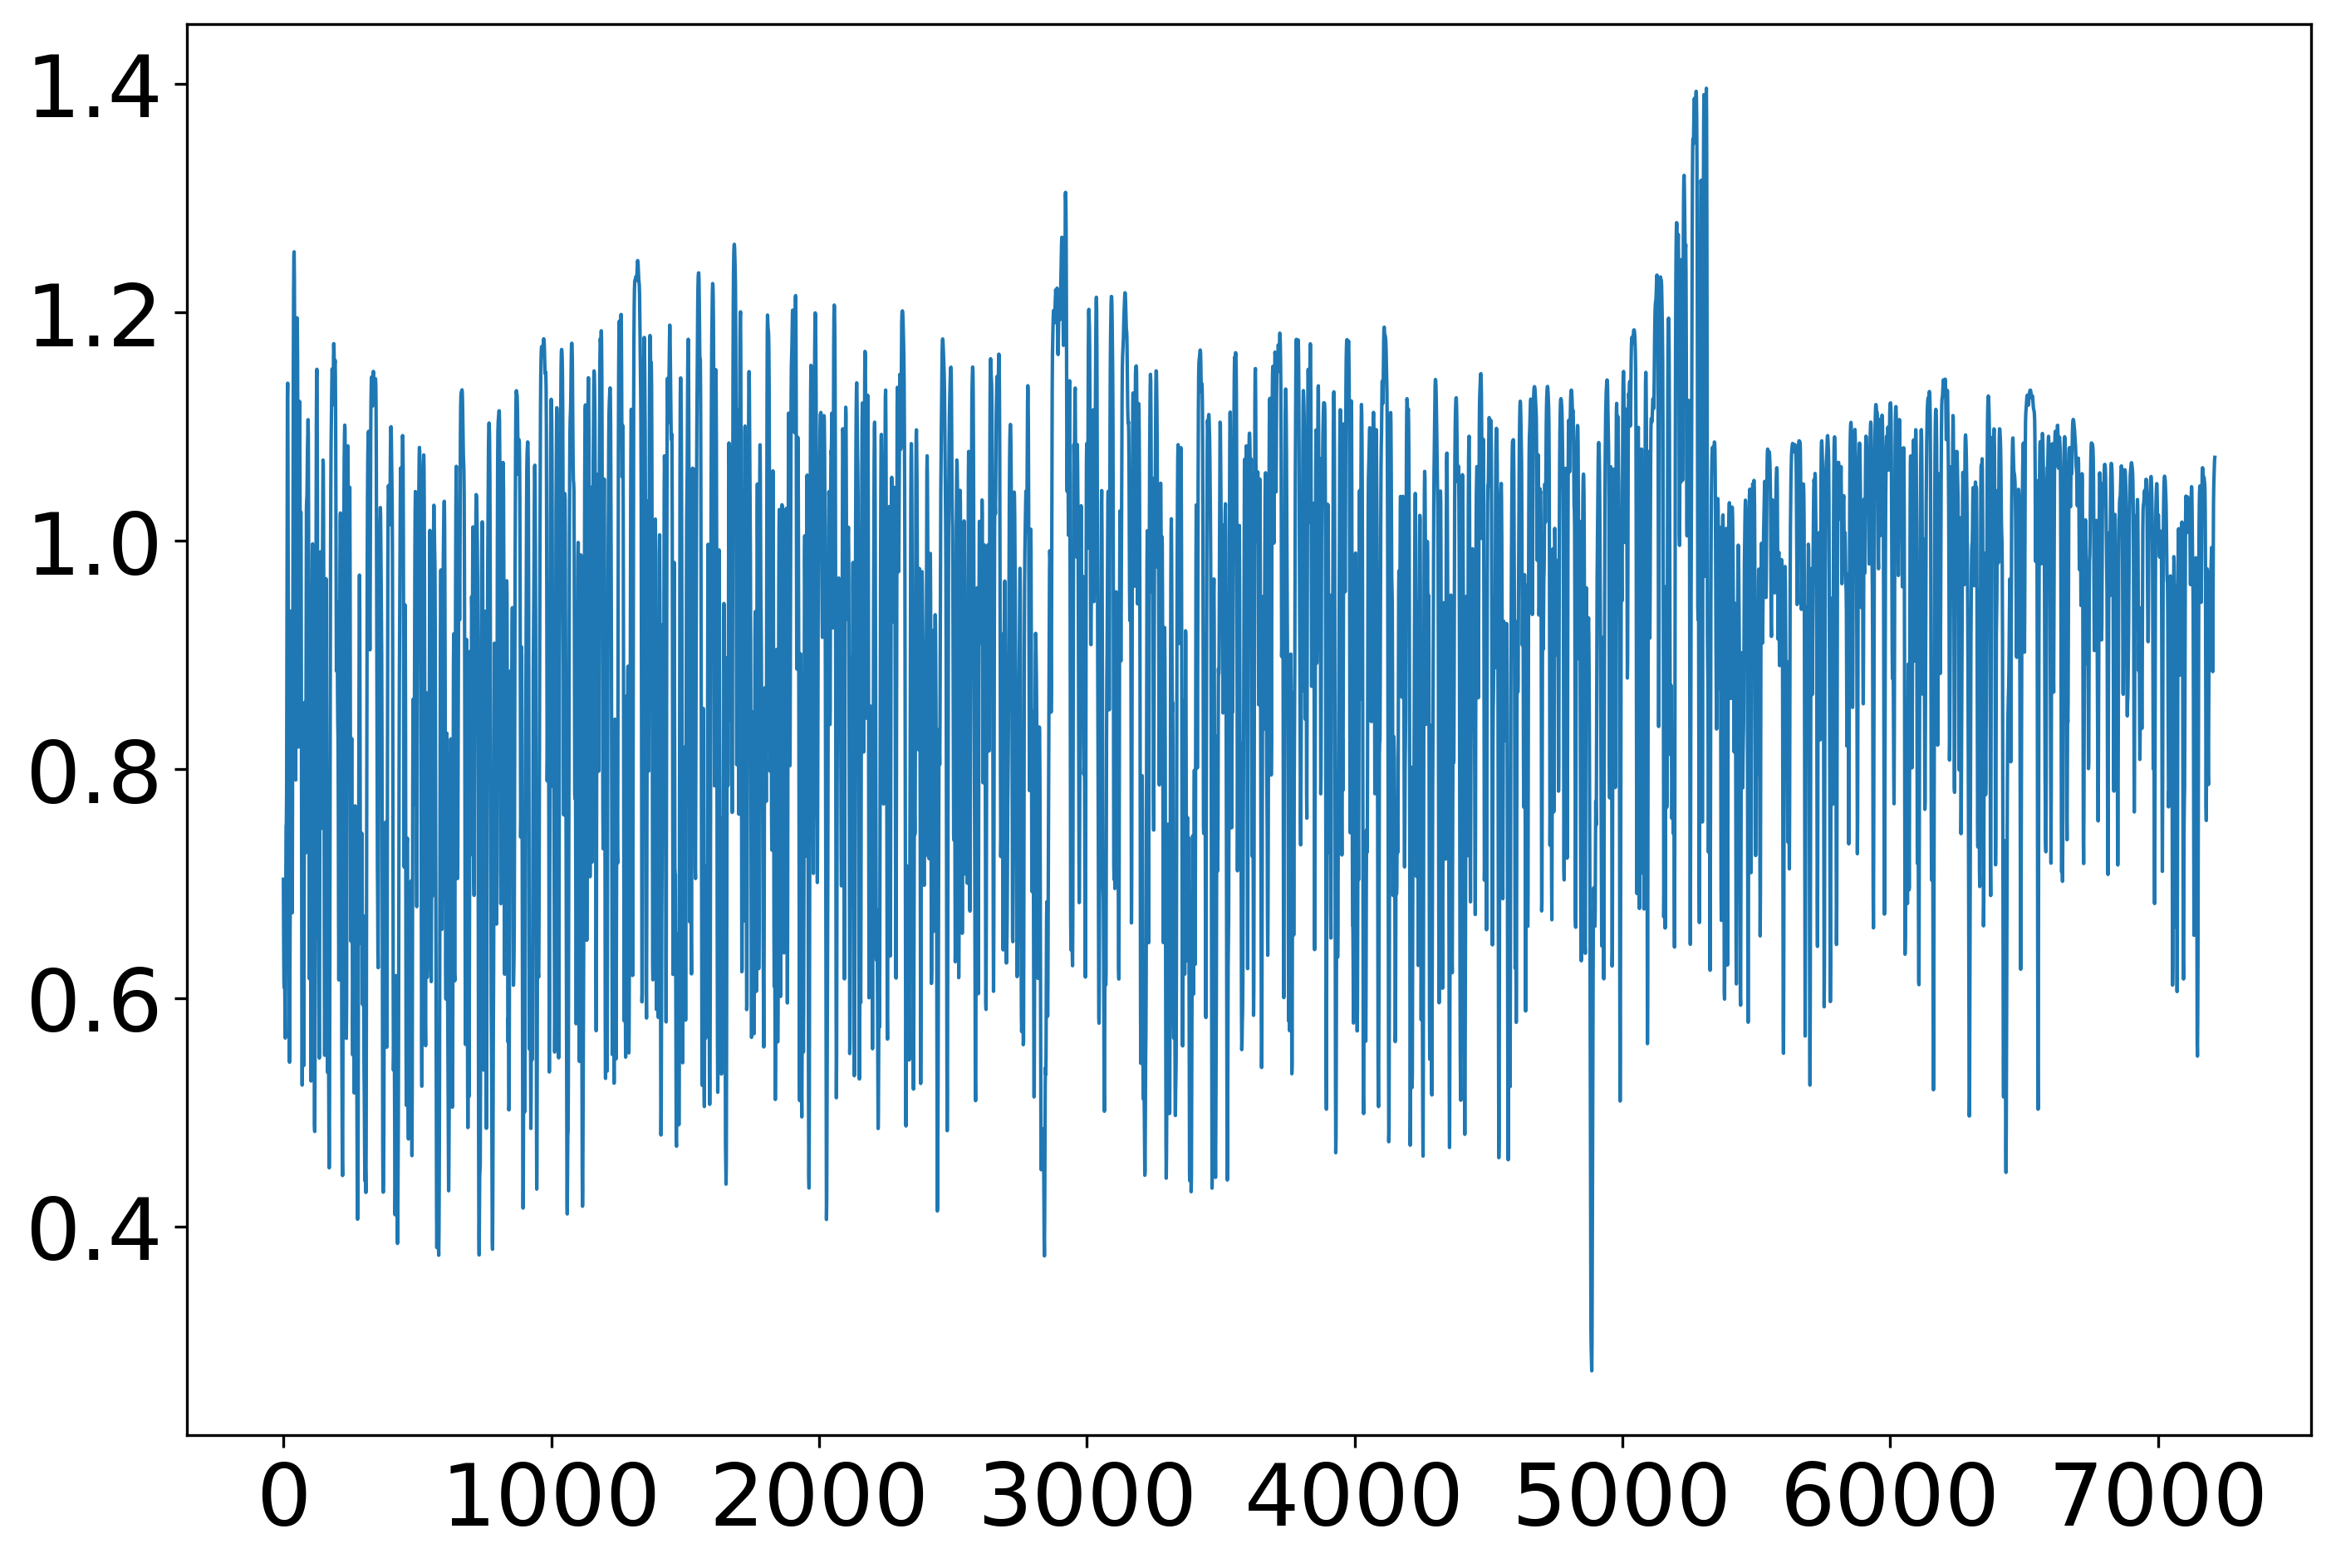

In [35]:
ind_sort = np.argsort(log_prob_x)
plt.plot(spectra[ind_sort[0],:])